In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
# Reading in Zillow data
df_raw = pd.read_csv('zillow_data.csv')
df_raw.head()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [3]:
# Import zipcode database to pair with data
df_Zipcode = pd.read_csv('zip_code_database.csv')

In [4]:
# Rename RegionName to Zipcode to merge data from zip code import
df_raw.rename(columns={'RegionName': 'Zipcode'}, inplace = True)

In [5]:
# Drop other columns and keep Zipcode (for merge), Lat/Long, and estimated Population
df_Zipcode.rename(columns={'zip':'Zipcode'}, inplace = True)
df_Zipcode = df_Zipcode[['Zipcode', 'latitude', 'longitude', 'irs_estimated_population' ]]
df_Zipcode.head()

,Zipcode,latitude,longitude,irs_estimated_population
0,501,40.81,-73.04,562
1,544,40.81,-73.04,0
2,601,18.16,-66.72,0
3,602,18.38,-67.18,0
4,603,18.43,-67.15,0


In [6]:
# Merge IRS Zipcode and Zillow data 
df = df_raw.merge(df_Zipcode, on = 'Zipcode')
df.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,41.94,-87.65,54760
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,41.92,-87.65,52800
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590


In [7]:
#Dividing zipcodes into region 
df_East = df[df_raw.Zipcode < 50000]
df_Central = df[(df_raw.Zipcode >= 50000) & (df_raw.Zipcode < 80000) ]

# West coast** 
df_West = df[(df.Zipcode >= 80000)]
df_West.head()

# Creating a California Data frame
cali_df_uf = df_West[(df_West['State'] == 'CA')]
cali_df_uf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224 entries, 9 to 14712
Columns: 275 entries, RegionID to irs_estimated_population
dtypes: float64(221), int64(50), object(4)
memory usage: 2.6+ MB


In [8]:
print(cali_df_uf.shape)
cali_df_uf.head()

(1224, 275)


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3799700,3793900,3778700,3770800,3763100,3779800,3813500,37.79,-122.42,39680
15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,594700,598500,601300,602800,606100,612400,616200,33.91,-118.34,85010
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,405400,408600,410900,413700,417900,424300,430100,38.01,-121.91,89590
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1903900,1907500,1922100,1952400,1974500,1975900,1966900,34.11,-118.36,35600
64,97711,94501,Alameda,CA,San Francisco,Alameda,65,222400.0,222300.0,222400.0,...,1000000,1009900,1021000,1032400,1042000,1053000,1059700,37.77,-122.27,56900


## Filtering Data
### 1) Population

In [9]:
# Mean of California population by zip code
cali_df_uf['irs_estimated_population'].mean()
# Dataframe filtered based on population average
cali_dff = cali_df_uf[(cali_df_uf.irs_estimated_population >= 28000)]

### 2) 'Middle Class' price percentiles

In [10]:
cali_dff['yr_avg']=cali_dff.iloc[:,-12:].mean(skipna=True, axis=1)
#Get zipcodes with an average value 1 decile above the median and 1.5 deciles below.
print(cali_dff['yr_avg'].describe(),'\n')
#Calculate the 75% cutoff value (1 decile above).
q_75 = cali_dff['yr_avg'].quantile(q=0.75)
print(f'Average Value 75% cutoff value: {round(q_75,2)}')
#Calculate the 25% cutoff value (1.5 deciles below).
q_25 = cali_dff['yr_avg'].quantile(q=0.25)
print(f'Average Value 25% cutoff value: {round(q_25,2)}')
#Get data frame with selected zipcodes.
cali_dff1 = cali_dff[(cali_dff['yr_avg']<q_75) & (cali_dff['yr_avg']>q_25)]
print(f'Amount of zipcodes: {len(cali_dff1)}')
# After filtering the percentiles
print(cali_dff1.shape)

count    5.440000e+02
mean     5.007335e+05
std      3.624352e+05
min      9.349306e+04
25%      2.906666e+05
50%      4.093647e+05
75%      5.722068e+05
max      2.839833e+06
Name: yr_avg, dtype: float64 

Average Value 75% cutoff value: 572206.75
Average Value 25% cutoff value: 290666.58
Amount of zipcodes: 272
(272, 276)


<ipython-input-10-2c79b9a71ee1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_dff['yr_avg']=cali_dff.iloc[:,-12:].mean(skipna=True, axis=1)


In [11]:
cali_dff1['ROI_5'] = round((cali_dff1['2018-04'] - cali_dff1['2010-01'])/ cali_dff1['2010-01'],4)
cali_dff1.head()

<ipython-input-11-8a52daa78f45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_dff1['ROI_5'] = round((cali_dff1['2018-04'] - cali_dff1['2010-01'])/ cali_dff1['2010-01'],4)


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,601300,602800,606100,612400,616200,33.91,-118.34,85010,457793.797500,0.6999
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,410900,413700,417900,424300,430100,38.01,-121.91,89590,316700.508333,1.5847
86,96025,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,87,119500.0,119500.0,119400.0,...,404200,409700,414300,418500,421100,33.95,-118.29,78060,309681.305000,1.0940
90,96239,90805,Long Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,91,128300.0,128100.0,127800.0,...,447700,451700,455000,457600,459100,33.86,-118.18,83830,341920.473333,0.7403
93,98325,95630,Folsom,CA,Sacramento,Sacramento,94,190000.0,189300.0,188500.0,...,537200,542400,544600,544100,542900,38.67,-121.14,69990,408717.294167,0.4223


In [12]:
#3rd DF with top 10 zipcodes based on histori 5-yr ROI
cali_df3 = cali_dff1.nlargest(10, 'ROI_5')
cali_df3.sort_values(by=['ROI_5'], ascending = False)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
1853,97850,94804,Richmond,CA,San Francisco,Contra Costa,1854,171300.0,170300.0,169400.0,...,448000,452400,459200,471800,483100,37.92,-122.34,38610,342635.465000,1.8434
1477,97803,94601,Oakland,CA,San Francisco,Alameda,1478,114600.0,114500.0,114500.0,...,535800,546900,555000,562000,566700,37.77,-122.21,45290,406675.463333,1.7024
310,97717,94509,Antioch,CA,San Francisco,Contra Costa,311,142500.0,141500.0,140400.0,...,390100,393600,397800,403500,408700,37.99,-121.81,59890,298875.515000,1.5883
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,410900,413700,417900,424300,430100,38.01,-121.91,89590,316700.508333,1.5847
1681,97808,94606,Oakland,CA,San Francisco,Alameda,1682,120400.0,120300.0,120300.0,...,663100,676500,683700,691700,696800,37.78,-122.24,30770,496223.795000,1.5846
2723,96655,92113,San Diego,CA,San Diego,San Diego,2724,89700.0,89500.0,89400.0,...,388100,393400,398300,402500,405000,32.69,-117.11,47450,295905.465000,1.5218
3121,97990,95122,San Jose,CA,San Jose,Santa Clara,3122,170800.0,170800.0,170900.0,...,700600,709100,720300,736700,748500,37.33,-121.83,53790,529383.791667,1.4892
2676,97984,95116,San Jose,CA,San Jose,Santa Clara,2677,170600.0,170700.0,171000.0,...,714800,726100,737700,753300,764500,37.35,-121.85,46110,537835.458333,1.4308
1191,95999,90018,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1192,133200.0,132900.0,132400.0,...,640300,643100,646400,652700,658000,34.02,-118.31,40590,482883.809167,1.3610
1469,98153,95376,Tracy,CA,Stockton,San Joaquin,1470,153300.0,153100.0,152900.0,...,417300,419700,423300,427500,429100,37.73,-121.42,50400,317043.025833,1.3487


In [47]:
%store cali_df3

Stored 'cali_df3' (DataFrame)


## EDA 

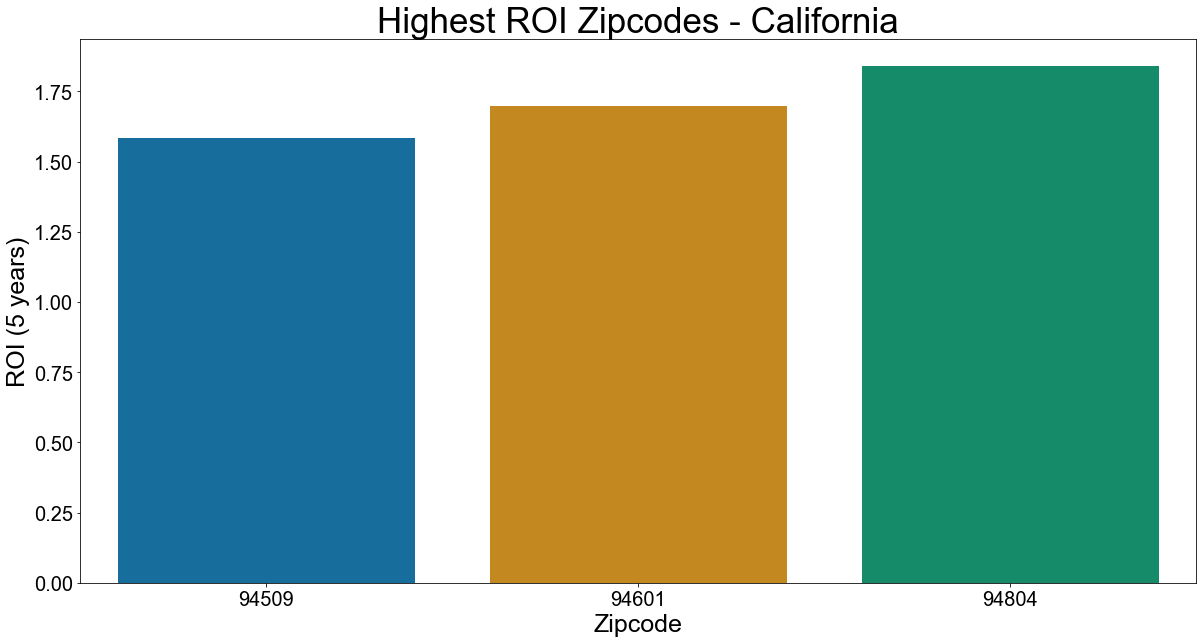

In [13]:
# Top 3 Zipcodes in CA (based on ROI)
fig, ax = plt.subplots(figsize = (20, 10))
sns.set(style = 'white')
palette = sns.set_palette(sns.color_palette("colorblind"))
p = sns.barplot(x = "Zipcode", y = 'ROI_5', data = cali_df3[:3], color = palette)
p.set_xlabel("Zipcode", fontsize = 25)
p.set_ylabel("ROI (5 years)", fontsize = 25)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
p.set_title("Highest ROI Zipcodes - California", fontsize = 35)

plt.show()

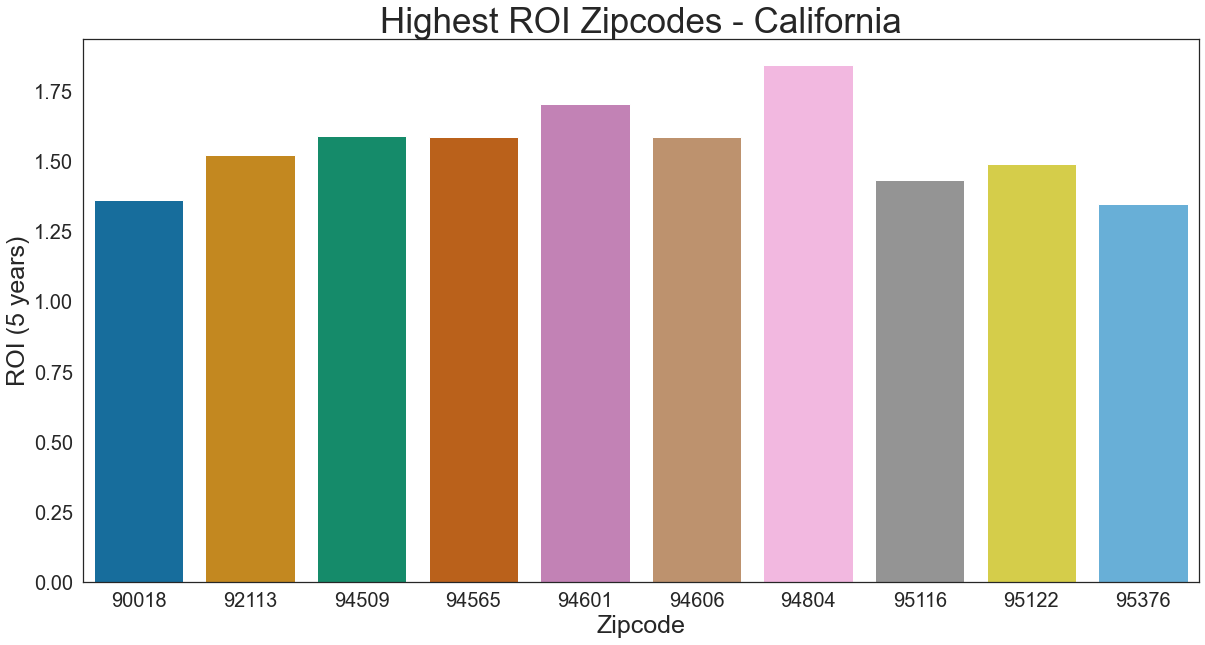

In [14]:
# Top 10 zipcodes in CA (based on 5 year ROI)

fig, ax = plt.subplots(figsize = (20, 10))
sns.set(style = 'white')
palette = sns.set_palette(sns.color_palette("colorblind"))
p = sns.barplot(x = "Zipcode", y = 'ROI_5', data = cali_df3, color = palette)
p.set_xlabel("Zipcode", fontsize = 25)
p.set_ylabel("ROI (5 years)", fontsize = 25)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
p.set_title("Highest ROI Zipcodes - California", fontsize = 35)

plt.show()

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

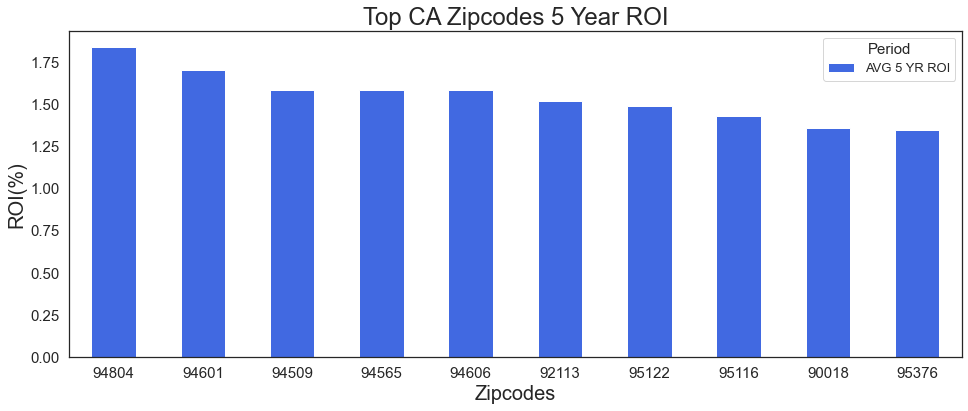

In [15]:
# Top 10 Zips in order
ax = cali_df3.sort_values('ROI_5',ascending=False).head(10).plot(x="Zipcode", y='ROI_5', kind="bar", figsize=(16,6), label = "AVG 5 YR ROI", color = "royalblue")

plt.title('Top CA Zipcodes 5 Year ROI', size=24)
plt.legend(loc='best', title='Period',  title_fontsize=15, fontsize=13)
plt.xlabel('Zipcodes', size=20)
plt.xticks(rotation='horizontal', fontsize=15)
plt.ylabel('ROI(%)', size=20)
plt.yticks(fontsize = 15)

In [16]:
# Map of top zipcodes 
cali_map = folium.Map([36.99, -119.78], zoom_start = 6.3, width = '75%')
for lat, lon in zip(cali_df3['latitude'][:3], cali_df3['longitude'][:3]):
    folium.CircleMarker([lat, lon], radius = 10, color = 'darkred').add_to(cali_map)
cali_map

<ipython-input-16-315b8aa98ee4>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for lat, lon in zip(cali_df3['latitude'][:3], cali_df3['longitude'][:3]):


## Time Series Modeling for Top 3 Zip Codes

In [17]:
# Creating a Dataframe for each zipcode to prepare for modeling
df94601 = cali_df3[cali_df3['Zipcode']== 94601]
df94509 = cali_df3[cali_df3['Zipcode']== 94509]
df94804 = cali_df3[cali_df3['Zipcode']== 94804]

In [18]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:-5], format='%Y-%m')

In [19]:
get_datetimes(df94601)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [20]:
get_datetimes(df94509)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [21]:
get_datetimes(df94804)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [22]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [23]:
# Melting time data (for Zipcode)
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['Zipcode', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName','latitude', 'longitude', 'irs_estimated_population','yr_avg', 'ROI_5']
                                 , var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('Date').aggregate({'value':'mean'}) 

In [24]:
# Melting all 3 zipcodes
melt94509 = melt_data(df94509)
melt94804 = melt_data(df94804)
melt94601 = melt_data(df94601)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


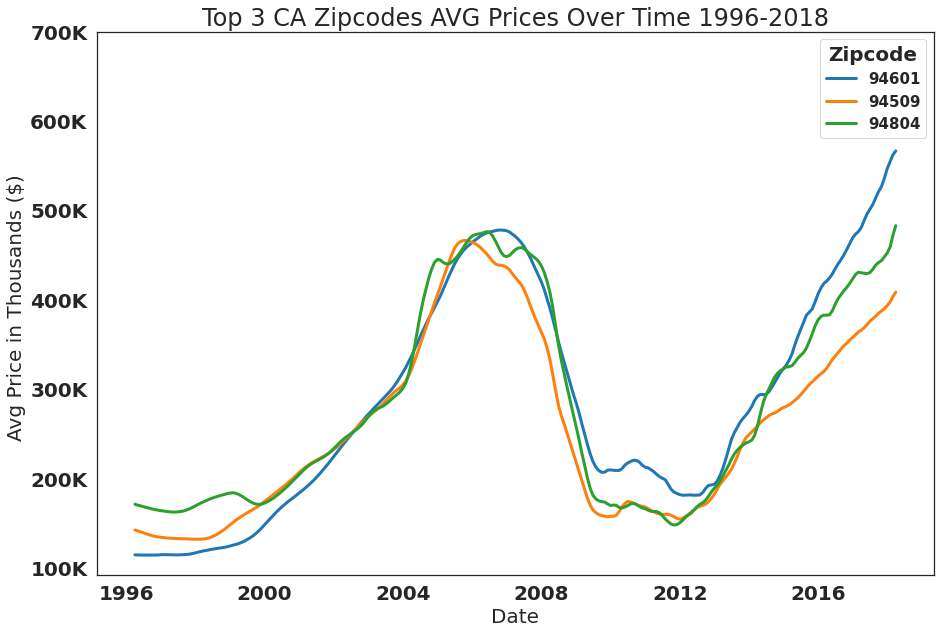

In [25]:
# Top 3 zipcodes from 1998-2018
plt.figure(figsize=(15,10))
w = melt94601
v = melt94509
u = melt94804
sns.set_palette("tab10")
sns.lineplot(x = "Date", y = "value", data=w, legend=False, linewidth = 3)
sns.lineplot(x = "Date", y = "value", data=v, legend=False, linewidth = 3)
sns.lineplot(x = "Date", y = "value", data=u, legend=False, linewidth = 3)
plt.title('Top 3 CA Zipcodes AVG Prices Over Time 1996-2018', size=24)
plt.xlabel('Date', size=20)
plt.xticks(rotation='horizontal', fontsize=20)
plt.ylabel('Avg Price in Thousands ($) ', size=20)
plt.yticks([100000,200000,300000,400000,500000, 600000, 700000],
           ["100K", "200K", "300K", "400K", "500K", "600K", "700K"], fontsize = 20)
#plt.plot([1996, 2018], [100000, 275000])
ax.set_xlim(pd.Timestamp('1996-04-01'), pd.Timestamp('2018-04-01'))
ax.set_ylim(-5, 5)
plt.legend(title='Zipcode', loc='best', labels=['94601', '94509','94804'],fontsize='15', title_fontsize='20')

In [26]:
# For the modeling, we will be doing a train test split with the data to train or model and test our performance

train601 = melt94601['2010':'2016-12']
test601 = melt94601['2017':]
combined601 = melt94601['2010':]

train509 = melt94509['2010':'2016-12']
test509 = melt94509['2017':]
combined509 = melt94509['2010':]

train804 = melt94804['2010':'2016-12']
test804 = melt94804['2017':]
combined804 = melt94804['2010':]

## Using Auto - ARIMA for each zipcode to find order/seasonal order

In [27]:
auto_model509 = pm.auto_arima(train509, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model509.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2319.995, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2264.434, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1522.328, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1442.092, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2255.121, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1437.498, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2255.437, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1408.276, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2258.607, Time=0.03 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=0.20 s

In [28]:
auto_model601 = pm.auto_arima(train601, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model601.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2352.596, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2296.846, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1583.992, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1468.447, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1472.035, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.228 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. 

In [29]:
auto_model804 = pm.auto_arima(train804, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model804.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2336.606, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2281.164, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1572.323, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2272.239, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.651 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   84
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -783.162
Date:        

### Will use best order and seasonal order, to plug into ARIMA model 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9050      0.053     36.256      0.000       1.802       2.008
ar.L2         -0.9039      0.053    -16.959      0.000      -1.008      -0.799
sigma2      8.855e+05   3.08e-09   2.88e+14      0.000    8.86e+05    8.86e+05


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


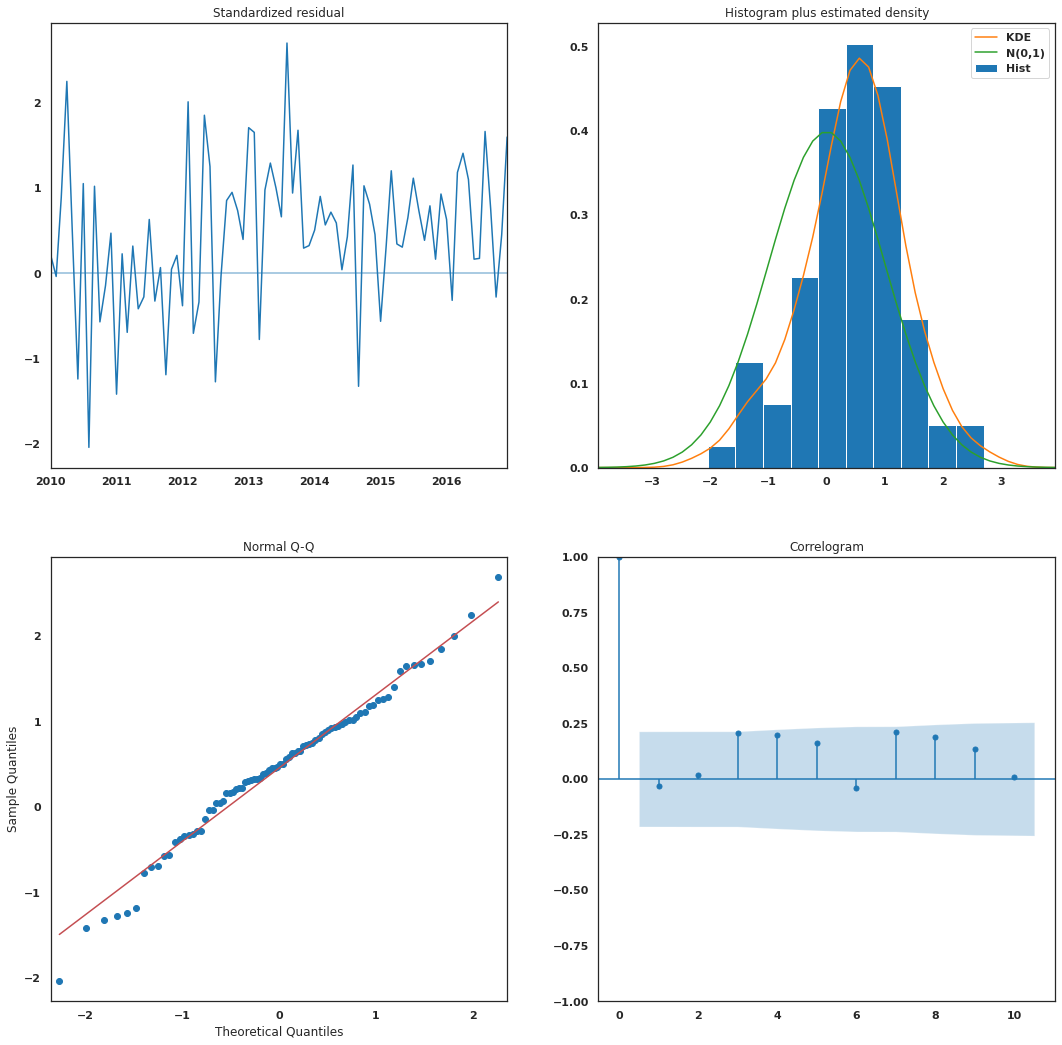

In [30]:
ARIMA_MODEL509 = sm.tsa.statespace.sarimax.SARIMAX(train509, 
                                        order=(2,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output509 = ARIMA_MODEL509.fit()

print(output509.summary().tables[1])
auto_model509.plot_diagnostics(figsize=(18,18))
plt.show()

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8327      0.042     43.480      0.000       1.750       1.915
ar.L2         -0.8304      0.043    -19.425      0.000      -0.914      -0.747
ma.L1          0.0095      0.022      0.424      0.672      -0.034       0.053
sigma2      2.003e+06   3.15e-09   6.35e+14      0.000       2e+06       2e+06


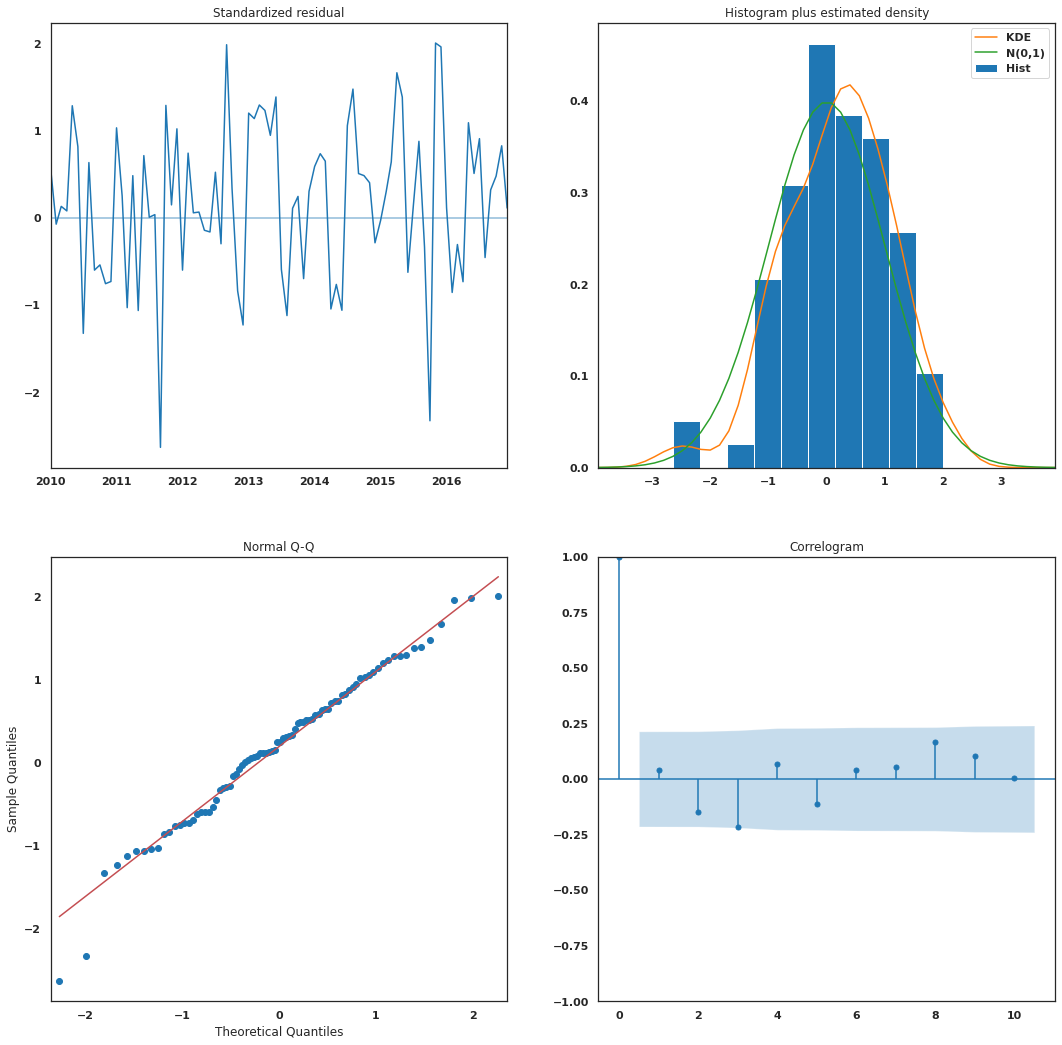

In [31]:
ARIMA_MODEL601 = sm.tsa.statespace.sarimax.SARIMAX(train601, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output601 = ARIMA_MODEL601.fit()

print(output601.summary().tables[1])
auto_model601.plot_diagnostics(figsize=(18,18))
plt.show()

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0129      0.002    455.954      0.000       1.009       1.017
ma.L1          0.8778      0.101      8.730      0.000       0.681       1.075
sigma2      4.986e+06   2.65e-09   1.88e+15      0.000    4.99e+06    4.99e+06


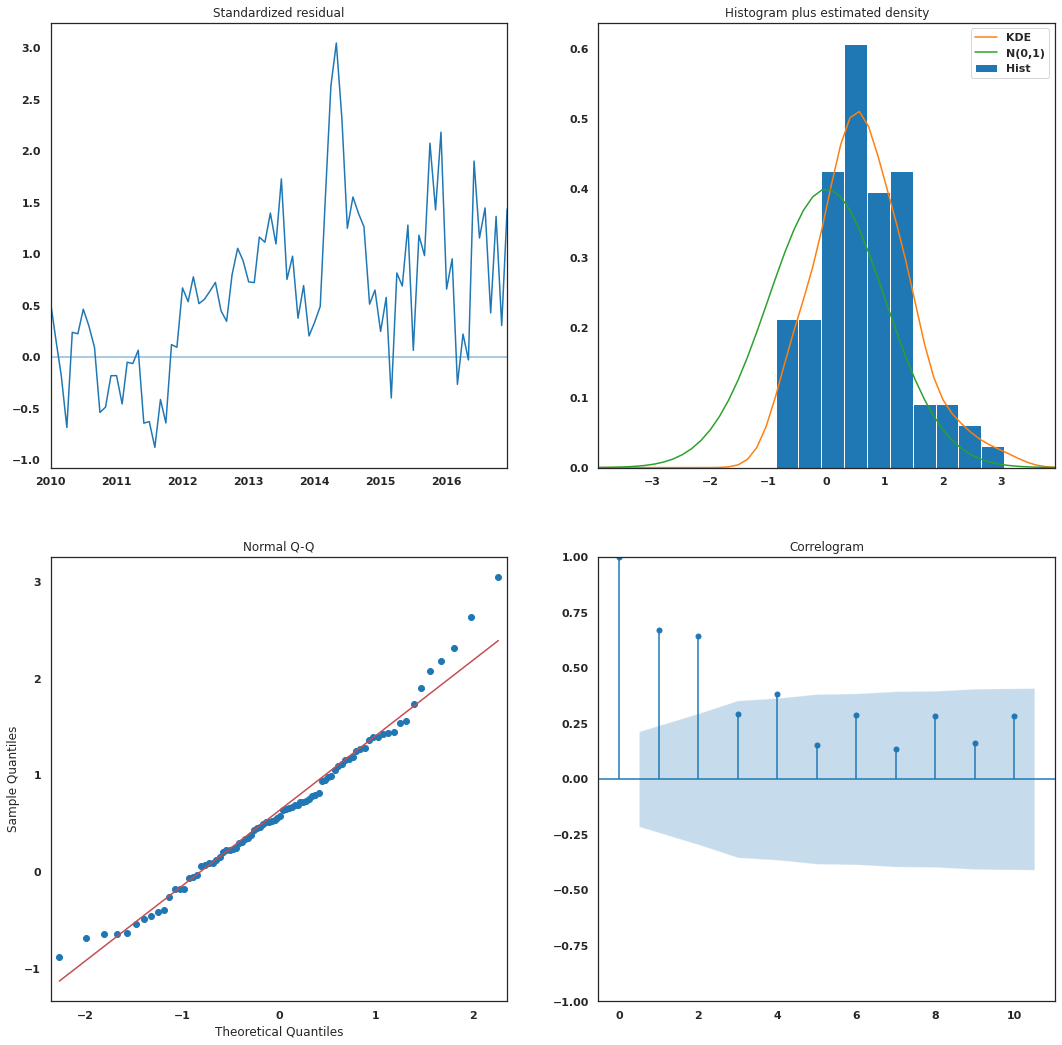

In [32]:
ARIMA_MODEL804 = sm.tsa.statespace.sarimax.SARIMAX(train804, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output804 = ARIMA_MODEL804.fit()

print(output804.summary().tables[1])
auto_model804.plot_diagnostics(figsize=(18,18))
plt.show()

### Making predictions based on models

In [33]:
pred509 = output509.get_prediction(start=pd.to_datetime('2017'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf509 = pred509.conf_int()
pred_conf509

,lower value,upper value
2017-01-01,356428.850690,360117.617064
2017-02-01,357748.206762,365684.538692
2017-03-01,358822.813527,371630.155637
2017-04-01,359748.394449,377853.591594
2017-05-01,360587.902234,384287.378088
2017-06-01,361384.901685,390884.005401
2017-07-01,362170.654126,397608.778935
2017-08-01,362968.106569,404435.777072
2017-09-01,363794.331446,411345.364083
2017-10-01,364662.117549,418322.556826


In [34]:
pred601 = output601.get_prediction(start=pd.to_datetime('2017'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf601 = pred601.conf_int()
pred_conf601

,lower value,upper value
2017-01-01,466597.254259,472144.351669
2017-02-01,469916.364473,481543.509601
2017-03-01,472947.872160,491239.851713
2017-04-01,475855.395997,501097.117413
2017-05-01,478739.089382,511037.955551
2017-06-01,481662.331894,521018.057557
2017-07-01,484665.915980,531012.647001
2017-08-01,487776.102742,541008.978409
2017-09-01,491009.528473,551001.885568
2017-10-01,494376.345589,560991.013644


In [35]:
pred804 = output804.get_prediction(start=pd.to_datetime('2017'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf804 = pred804.conf_int()
pred_conf804

,lower value,upper value
2017-01-01,419911.659274,428664.571531
2017-02-01,420399.196208,439120.548815
2017-03-01,422737.620571,447866.769777
2017-04-01,425752.275890,456079.710964
2017-05-01,429170.064063,464034.314022
2017-06-01,432874.821219,471848.610141
2017-07-01,436804.671018,479586.367063
2017-08-01,440922.277774,487286.836267
2017-09-01,445203.245705,494976.354037
2017-10-01,449630.735131,502673.725576


In [36]:
ARIMA_MODEL804 = sm.tsa.statespace.sarimax.SARIMAX(combined804, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output804 = ARIMA_MODEL804.fit()

print(output804.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0129      0.002    455.954      0.000       1.009       1.017
ma.L1          0.8778      0.101      8.730      0.000       0.681       1.075
sigma2      4.986e+06   2.65e-09   1.88e+15      0.000    4.99e+06    4.99e+06


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [37]:
ARIMA_MODEL601 = sm.tsa.statespace.sarimax.SARIMAX(combined601, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output601 = ARIMA_MODEL601.fit()

print(output601.summary().tables[1])

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8327      0.042     43.480      0.000       1.750       1.915
ar.L2         -0.8304      0.043    -19.425      0.000      -0.914      -0.747
ma.L1          0.0095      0.022      0.424      0.672      -0.034       0.053
sigma2      2.003e+06   3.15e-09   6.35e+14      0.000       2e+06       2e+06


In [38]:
ARIMA_MODEL509 = sm.tsa.statespace.sarimax.SARIMAX(combined509, 
                                        order=(2,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output509 = ARIMA_MODEL509.fit()

print(output509.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9050      0.053     36.256      0.000       1.802       2.008
ar.L2         -0.9039      0.053    -16.959      0.000      -1.008      -0.799
sigma2      8.855e+05   3.08e-09   2.88e+14      0.000    8.86e+05    8.86e+05


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Testing Model performance (plots)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


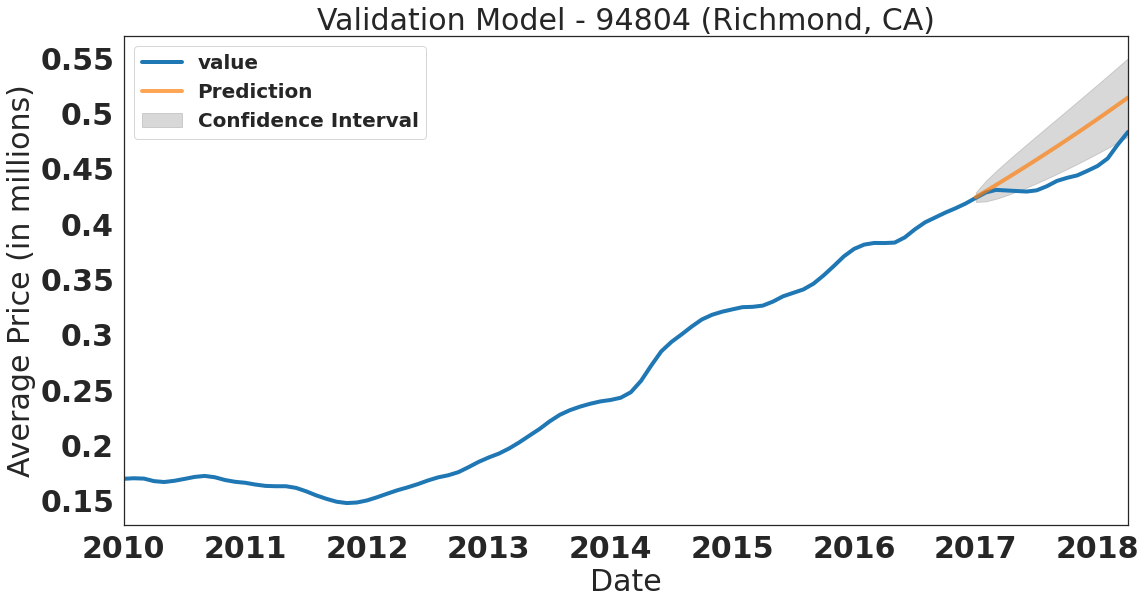

In [39]:
#Zipcode 94804 Model (Top Zip)

rcParams['figure.figsize'] = 18, 9
ax = combined804.plot(label='observed', linewidth = 4)

pred804.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.7, linewidth = 4)


ax.fill_between(pred_conf804.index,
                pred_conf804.iloc[:, 0],
                pred_conf804.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Average Price (in millions)',fontsize=30)
plt.yticks(fontsize=30)
#Changing the y scale to ($) Millions
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model - 94804 (Richmond, CA)',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [40]:
forecast509 = full_output509.get_forecast(60)
future_prediction509 = forecast509.conf_int()
future_prediction509['value'] = forecast509.predicted_mean
future_prediction509.columns = ['lower','upper','prediction'] 
future_prediction509

,lower,upper,prediction
2018-05-01,412090.430976,415617.587150,413854.009063
2018-06-01,415184.174015,422761.026062,418972.600038
2018-07-01,417960.345718,430170.149867,424065.247793
2018-08-01,420521.765265,437759.134647,429140.449956
2018-09-01,422938.368813,445473.300112,434205.834463
2018-10-01,425260.290045,453276.220622,439268.255334
2018-11-01,427524.839636,461142.916344,444333.877990
2018-12-01,429760.477873,469056.032595,449408.255234
2019-01-01,431989.274516,477003.515342,454496.394929
2019-02-01,434228.534683,484977.105880,459602.820281


In [41]:
forecast601 = full_output601.get_forecast(60)
future_prediction601 = forecast601.conf_int()
future_prediction601['value'] = forecast601.predicted_mean
future_prediction601.columns = ['lower','upper','prediction'] 
future_prediction601

,lower,upper,prediction
2018-05-01,5.690173e+05,5.749101e+05,5.719637e+05
2018-06-01,5.716923e+05,5.837239e+05,5.777081e+05
2018-07-01,5.745971e+05,5.930750e+05,5.838361e+05
2018-08-01,5.778018e+05,6.027480e+05,5.902749e+05
2018-09-01,5.813231e+05,6.126172e+05,5.969701e+05
2018-10-01,5.851540e+05,6.226080e+05,6.038810e+05
2018-11-01,5.892777e+05,6.326766e+05,6.109771e+05
2018-12-01,5.936738e+05,6.427980e+05,6.182359e+05
2019-01-01,5.983220e+05,6.529593e+05,6.256406e+05
2019-02-01,6.032033e+05,6.631547e+05,6.331790e+05


In [42]:
forecast804 = full_output804.get_forecast(60)
future_prediction804 = forecast804.conf_int()
future_prediction804['value'] = forecast804.predicted_mean
future_prediction804.columns = ['lower','upper','prediction'] 
future_prediction804

,lower,upper,prediction
2018-05-01,485114.086660,4.942158e+05,489664.958055
2018-06-01,485606.439325,5.051497e+05,495378.052460
2018-07-01,488042.414732,5.142732e+05,501157.803561
2018-08-01,491182.896138,5.228271e+05,507004.989064
2018-09-01,494740.676751,5.311001e+05,512920.395750
2018-10-01,498593.560465,5.392161e+05,518904.819579
2018-11-01,502676.382458,5.472417e+05,524959.065800
2018-12-01,506949.749871,5.552181e+05,531083.949055
2019-01-01,511387.856670,5.631727e+05,537280.293491
2019-02-01,515972.829752,5.711250e+05,543548.932871


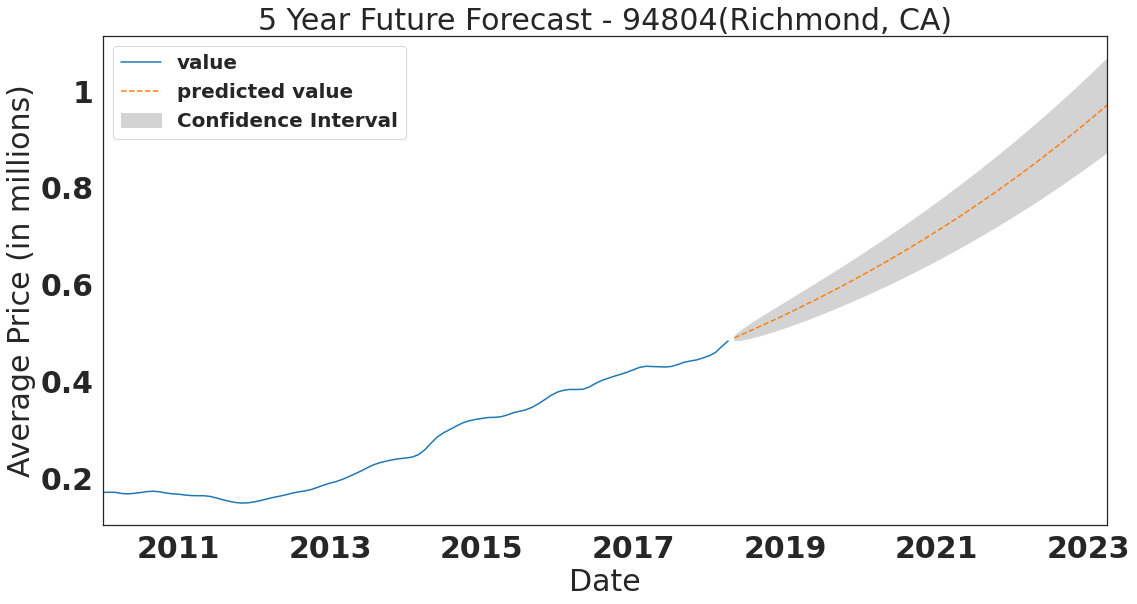

In [43]:
# Forecast Model 
fig, ax = plt.subplots()
combined804.plot(ax=ax,label='Real Values')


future_prediction804['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction804.index, y1= future_prediction804['lower'], 
                y2= future_prediction804['upper'], color = 'lightgrey',
                label='Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Average Price (in millions)',fontsize=30)
plt.yticks(fontsize=30)

scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('5 Year Future Forecast - 94804(Richmond, CA)',fontsize=30)
plt.legend(fontsize = 20)
plt.show()

## Forecast of 5 Year Returns (ROI's) from top 3 zipcodes

In [44]:
five_yr_return_94509 = (future_prediction509.iloc[-1,2]-melt94509.iloc[-1])*100/melt94509.iloc[-1]
round(five_yr_return_94509[0],2)

91.38

In [45]:
five_yr_return_94601 = (future_prediction601.iloc[-1,2]-melt94601.iloc[-1])*100/melt94601.iloc[-1]
round(five_yr_return_94601[0],2)

105.34

In [46]:
five_yr_return_94804 = (future_prediction804.iloc[-1,2]-melt94804.iloc[-1])*100/melt94804.iloc[-1]
round(five_yr_return_94804[0],2)

100.95